### Example

This example shows how to analyze a pcap to make a simple graph: the aggregate rate of TCP and UDP packets in a trace. 

You can run the code in the notebook, or copy/paste it to a python script.

In [10]:
import dpkt
import binascii
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

#### Parsing pcaps
First, open a PCAP file and parse its contents with dpkt. Its simple, but here are a few tutorials for reference:

https://jon.oberheide.org/blog/2008/10/15/dpkt-tutorial-2-parsing-a-pcap-file/

https://dpkt.readthedocs.io/en/latest/examples.html

In [5]:
pcap_fn = "example.pcap"
pcap = dpkt.pcap.Reader(open(pcap_fn, "rb"))

parsed_recs = [] # the data we're parsing out of the pcaps
for (ts, buf) in pcap:
  # 'buf' is a raw buffer of packets, we cast to an ethernet object.
  eth = dpkt.ethernet.Ethernet(buf)
  # 'eth' has local variables corresponding to ethernet header fields, e.g., source, dest, etc. 
  if (isinstance(eth.data, dpkt.ip.IP)):
    ip = eth.data
    if (isinstance(ip.data, dpkt.tcp.TCP)):
      parsed_recs.append(
        {
          "protocol":"TCP",
          "time":ts,
          "bytes":ip.len
        }
      )
    elif (isinstance(ip.data, dpkt.udp.UDP)):
      parsed_recs.append(
        {
          "protocol":"UDP",
          "time":ts,
          "bytes":ip.len
        }
      )
print ("parsed %s packets"%len(parsed_recs))          
  


parsed 99197 packets


Next, convert the parsed data into a pandas dataframe. Pandas has a ton of built-in methods for aggregating data and computing statistics, and easy ways to manipulate the data for when we want to calculate things with our own methods. 

In [144]:
packet_df = pd.DataFrame(parsed_recs)
# convert time to relative time since start of trace.
packet_df["time_since_start"] = pd.to_datetime(packet_df["time"], unit='s')
packet_df['time_since_start'] = packet_df['time_since_start'] - min(packet_df['time_since_start']) 
print (packet_df)



      protocol          time  bytes          time_since_start
0          UDP  1.361916e+09   1154           0 days 00:00:00
1          UDP  1.361916e+09   1154 0 days 00:00:00.000050068
2          UDP  1.361916e+09     80 0 days 00:00:00.000050068
3          TCP  1.361916e+09     40 0 days 00:00:00.000322104
4          UDP  1.361916e+09    153 0 days 00:00:00.001160145
...        ...           ...    ...                       ...
99192      TCP  1.361916e+09     52 0 days 00:00:34.392866135
99193      TCP  1.361916e+09   1500 0 days 00:00:34.392924071
99194      TCP  1.361916e+09     52 0 days 00:00:34.392992020
99195      TCP  1.361916e+09   1320 0 days 00:00:34.393042088
99196      TCP  1.361916e+09     52 0 days 00:00:34.393100024

[99197 rows x 4 columns]


In [145]:
# aggregate the data by second and compute the total number of bytes.
agg_df = packet_df.groupby([pd.Grouper(key="time_since_start", freq='1S'), 'protocol']).sum().reset_index()
# add a column to the aggregate data that is megabits per second.
agg_df['Mb/s'] = agg_df.bytes * 8 / 1000000
agg_df['time_since_start'] = agg_df['time_since_start'].dt.total_seconds()
print (agg_df)

    time_since_start protocol          time    bytes       Mb/s
0                0.0      TCP  3.054778e+12   757694   6.061552
1                0.0      UDP  7.245394e+11   128933   1.031464
2                1.0      TCP  2.367010e+12   523747   4.189976
3                1.0      UDP  7.027487e+11   109452   0.875616
4                2.0      TCP  3.269961e+12   888510   7.108080
..               ...      ...           ...      ...        ...
65              32.0      UDP  7.272632e+11   116602   0.932816
66              33.0      TCP  3.604992e+12  1477889  11.823112
67              33.0      UDP  7.218156e+11   123753   0.990024
68              34.0      TCP  1.774577e+12   763175   6.105400
69              34.0      UDP  3.254980e+11    51779   0.414232

[70 rows x 5 columns]


Finally, plot the data with seaborn, a plotting library built around pandas. It has a lot of very powerful plotting functions. This uses lineplot: https://seaborn.pydata.org/generated/seaborn.lineplot.html

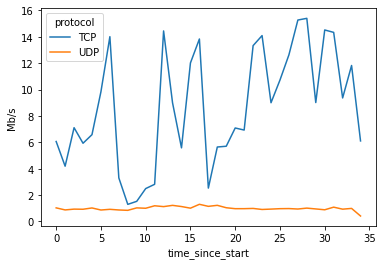

In [146]:
sns.lineplot(data=agg_df, x="time_since_start", y="Mb/s", hue="protocol") 
plt.show()